In [ ]:
!pip install pillow-avif-plugin


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 40.0 MB/s eta 0:00:00


In [ ]:
from PIL import Image
import pillow_avif  # registers AVIF support
import os

# AVIF images
image_files = [
    'cat_1.avif', 'cat_2.avif', 'cat_3.avif', 'cat_4.avif',
    'dog_1.avif', 'dog_2.avif', 'dog_3.avif', 'dog_4.avif', 'dog_5.avif', 'dog_6.avif',
    'aquatic_1.avif','aquatic_4.avif','aquatic_5.avif', 'desserts_1.avif', 'desserts_2.avif', 'desserts_3.avif',
    'desserts_4.avif', 'mountains_1.avif',  'mountains_2.avif', 'mountains_3.avif'
]

# Output directory
output_dir = 'converted_images'
os.makedirs(output_dir, exist_ok=True)

# Convert each AVIF to JPG
for file in image_files:
    with Image.open(file) as img:
        img = img.convert("RGB")
        output_path = os.path.join(output_dir, file.replace('.avif', '.jpg'))
        img.save(output_path, format='JPEG')

print("[INFO] Conversion complete. Check 'converted_images/' folder.")


[INFO] Conversion complete. Check 'converted_images/' folder.


In [ ]:
from transformers import Blip2Processor, Blip2ForConditionalGeneration
from PIL import Image
import torch
import os
import json

image_directory = "converted_images"


print("Loading BLIP2 model...")
processor = Blip2Processor.from_pretrained("Salesforce/blip2-opt-2.7b")
model = Blip2ForConditionalGeneration.from_pretrained(
    "Salesforce/blip2-opt-2.7b",
    device_map="auto",
    torch_dtype=torch.float16
)


image_files = [f for f in os.listdir(image_directory)
               if os.path.isfile(os.path.join(image_directory, f))
               and f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))]

print(f"Found {len(image_files)} images in the directory")


captions = {}


for image_file in image_files:
    full_image_path = os.path.join(image_directory, image_file)

    try:

        image = Image.open(full_image_path).convert("RGB")


        inputs = processor(images=image, return_tensors="pt").to(model.device)
        output = model.generate(**inputs, max_length=50)
        caption = processor.decode(output[0], skip_special_tokens=True)

        captions[image_file] = caption


        print(f"Image: {image_file}")
        print(f"Caption: {caption}")
        print("-" * 50)

    except Exception as e:
        print(f"Error processing {image_file}: {str(e)}")

with open('image_captions.json', 'w') as f:
    json.dump(captions, f, indent=2)

print(f"Processed {len(captions)} images. Captions saved to image_captions.json")

Loading BLIP2 model...


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Found 20 images in the directory


In [ ]:
import json
import numpy as np
import random

# --- Load captions ---
with open('image_captions.json', 'r') as f:
    captions = json.load(f)

image_names = list(captions.keys())
caption_texts = list(captions.values())

# --- Preprocess captions into sets ---
def preprocess(text):
    return set(text.lower().split())

caption_sets = [preprocess(caption) for caption in caption_texts]

# --- Create characteristic matrix ---
def create_characteristic_matrix(caption_sets, universal_set):
    matrix = []
    for word in universal_set:
        row = [1 if word in caption else 0 for caption in caption_sets]
        matrix.append(row)
    return np.array(matrix)

universal_set = list(set.union(*caption_sets))
char_matrix = create_characteristic_matrix(caption_sets, universal_set)

# --- Generate hash functions ---
def generate_hash_functions(num_funcs, max_val):
    hash_funcs = []
    c = 10007  # large prime
    for _ in range(num_funcs):
        a = random.randint(1, c - 1)
        b = random.randint(0, c - 1)
        hash_funcs.append(lambda x, a=a, b=b: (a * x + b) % c)
    return hash_funcs

# --- Compute MinHash signatures ---
def compute_minhash_signature_matrix(char_matrix, num_hashes=100):
    num_rows, num_cols = char_matrix.shape
    signature = np.full((num_hashes, num_cols), np.inf)
    hash_funcs = generate_hash_functions(num_hashes, num_rows)

    for row in range(num_rows):
        for i, h in enumerate(hash_funcs):
            hash_val = h(row)
            for col in range(num_cols):
                if char_matrix[row][col] == 1:
                    if hash_val < signature[i][col]:
                        signature[i][col] = hash_val
    return signature.astype(int)

signature_matrix = compute_minhash_signature_matrix(char_matrix, num_hashes=100)



Resolved Queries:
 → dog_6.jpg
 → desserts_3.jpg
 → mountains_1.jpg
 → aquatic_5.jpg


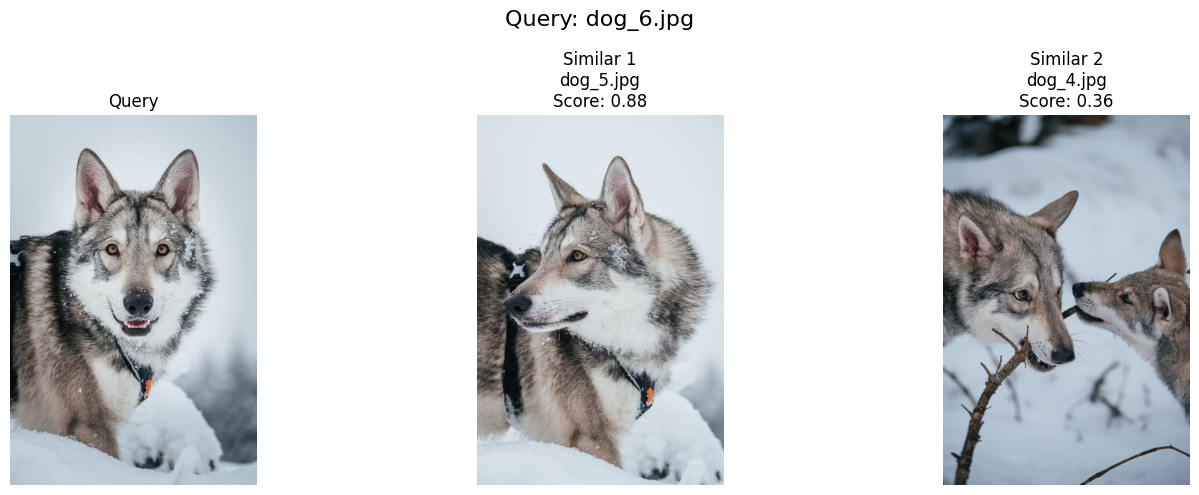

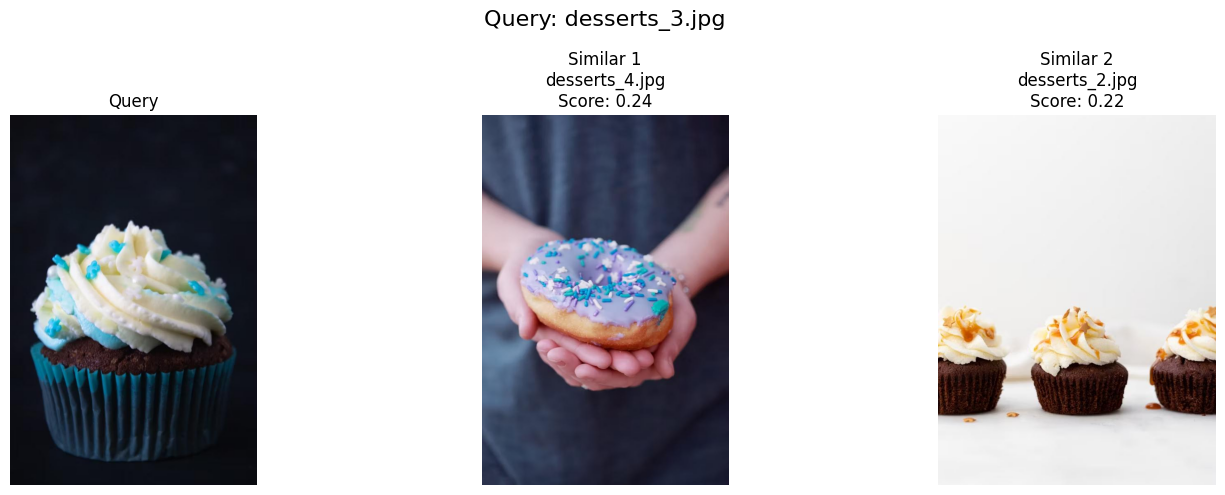

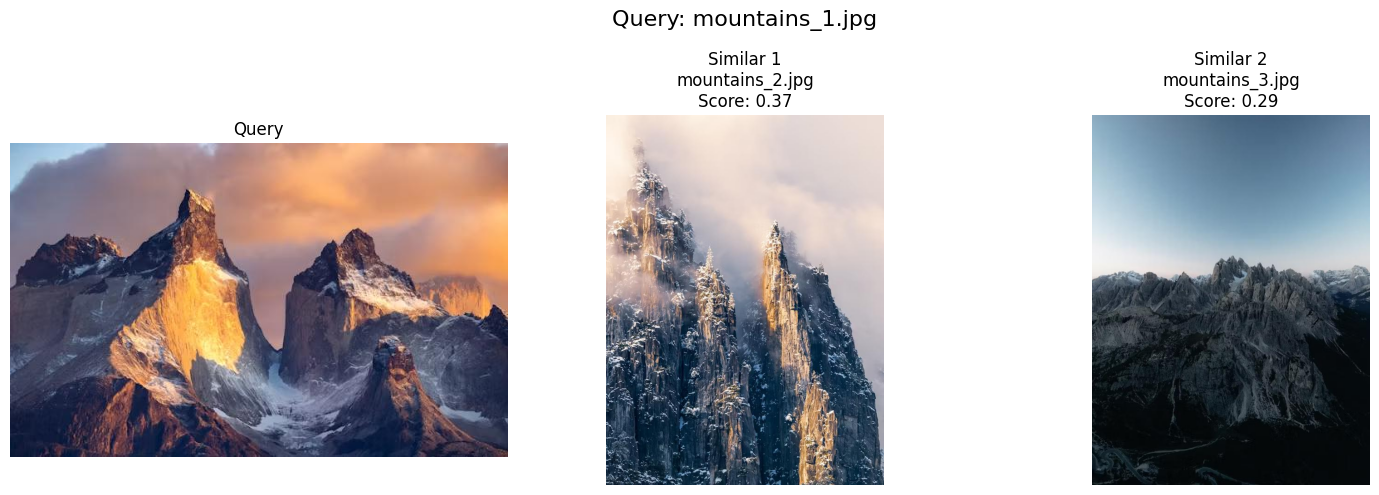

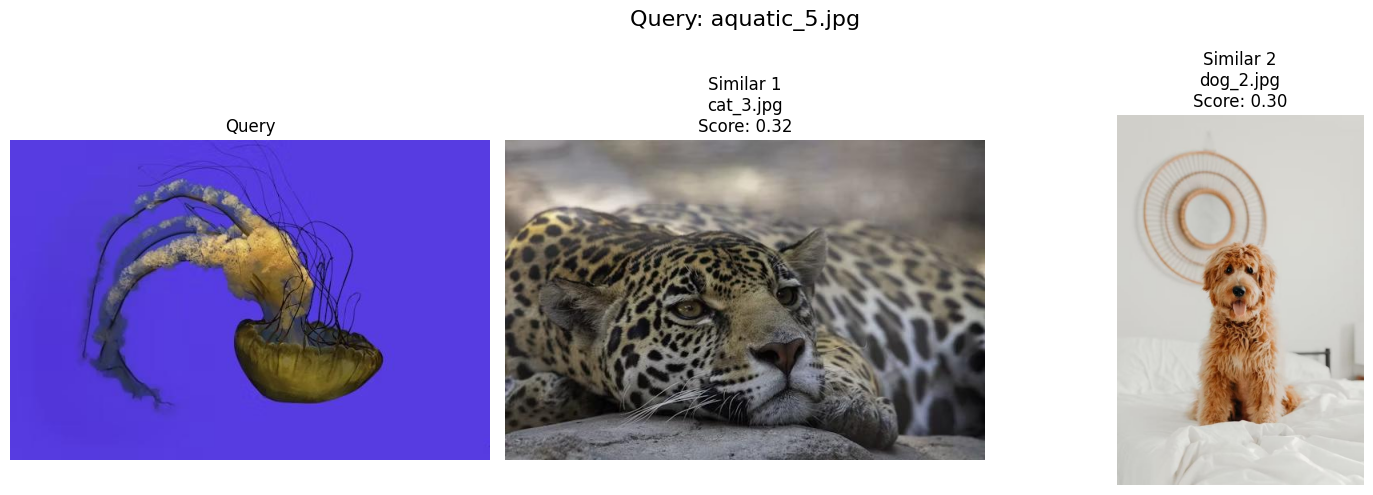

In [ ]:
# ==== Step 4: Resolve Queries (filenames or caption keywords) ====
raw_queries = ["dog_6.jpg", "desserts_3.jpg", "mountains_1.jpg", "aquatic_5.jpg"]
resolved_queries = []

for query in raw_queries:
    if query in image_names:
        resolved_queries.append(query)
    else:
        found = False
        for name, caption in captions.items():
            if query.lower() in caption.lower():
                resolved_queries.append(name)
                found = True
                break
        if not found:
            print(f"Query '{query}' not found in any caption or filename.")

print("\nResolved Queries:")
for q in resolved_queries:
    print(f" → {q}")
# ==== Step 5: Find Top-2 Similar Images ====
def find_top_k_similar_for_queries(query_images, signature_matrix, image_names, k=2):
    results = {}
    for query_image in query_images:
        try:
            query_idx = image_names.index(query_image)
        except ValueError:
            print(f"Image '{query_image}' not found.")
            continue

        query_sig = signature_matrix[:, query_idx]
        similarities = []
        for i, name in enumerate(image_names):
            if i == query_idx:
                continue
            sim = np.mean(query_sig == signature_matrix[:, i])
            similarities.append((name, sim))

        similarities.sort(key=lambda x: x[1], reverse=True)
        results[query_image] = similarities[:k]
    return results

top_k_results = find_top_k_similar_for_queries(resolved_queries, signature_matrix, image_names, k=2)

# ==== Step 6: Visualize Results ====
def show_similar_images(query_results, image_dir="converted_images"):
    for query_img, similar_list in query_results.items():
        fig, axs = plt.subplots(1, 3, figsize=(15, 5))
        fig.suptitle(f"Query: {query_img}", fontsize=16)

        # Query image
        try:
            axs[0].imshow(Image.open(os.path.join(image_dir, query_img)))
            axs[0].set_title("Query")
            axs[0].axis("off")
        except Exception as e:
            axs[0].set_title("Query Not Found")
            axs[0].axis("off")
            print(f"Error loading query image '{query_img}': {e}")

        # Similar images
        for i, (sim_img, score) in enumerate(similar_list):
            try:
                axs[i+1].imshow(Image.open(os.path.join(image_dir, sim_img)))
                axs[i+1].set_title(f"Similar {i+1}\n{sim_img}\nScore: {score:.2f}")
                axs[i+1].axis("off")
            except Exception as e:
                axs[i+1].set_title(f"Error loading {sim_img}")
                axs[i+1].axis("off")
                print(f"Error loading similar image '{sim_img}': {e}")

        plt.tight_layout()
        plt.show()

# ==== Step 7: Run Visualization ====
show_similar_images(top_k_results, image_dir=image_directory)


Resolved Queries:
 → dog_2.jpg
 → desserts_3.jpg
 → mountains_2.jpg
 → aquatic_5.jpg


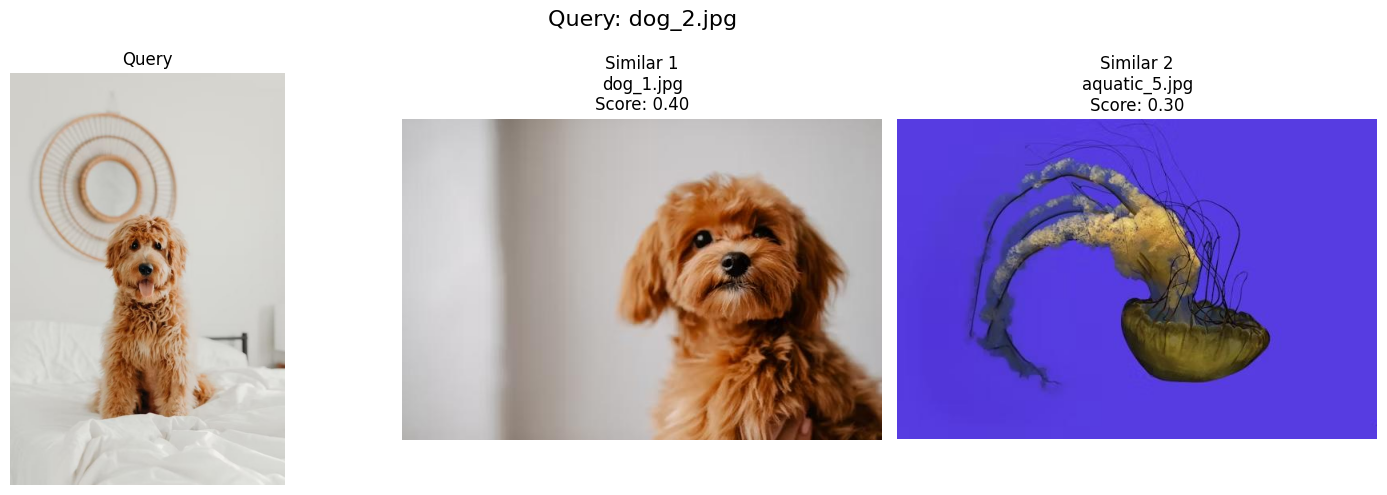

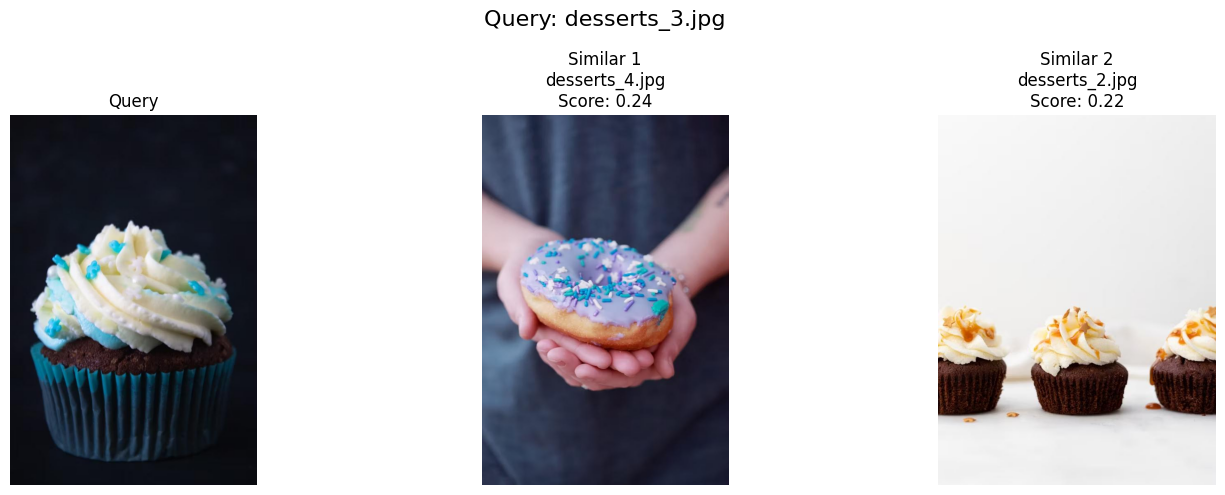

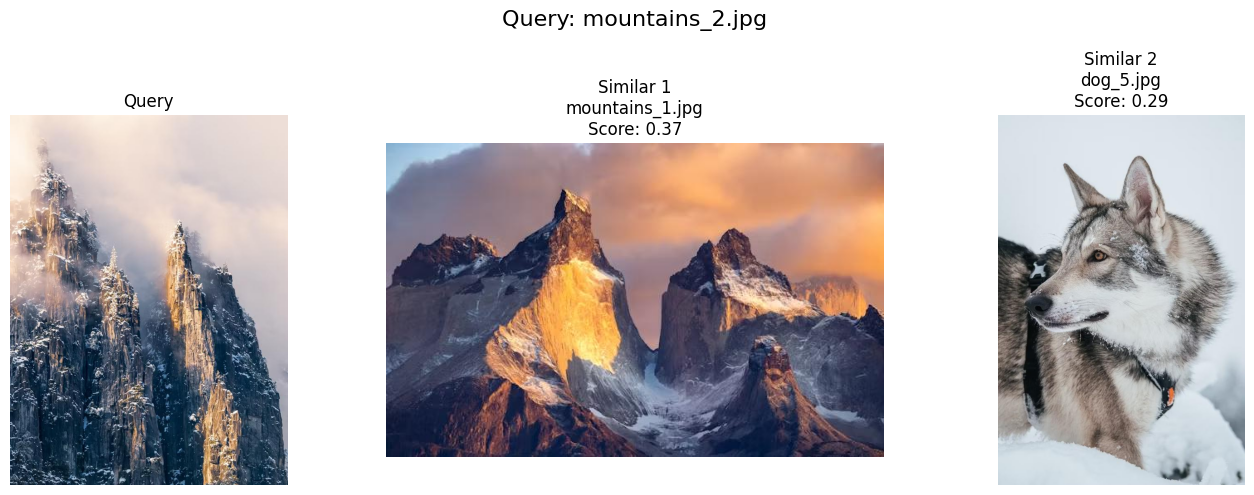

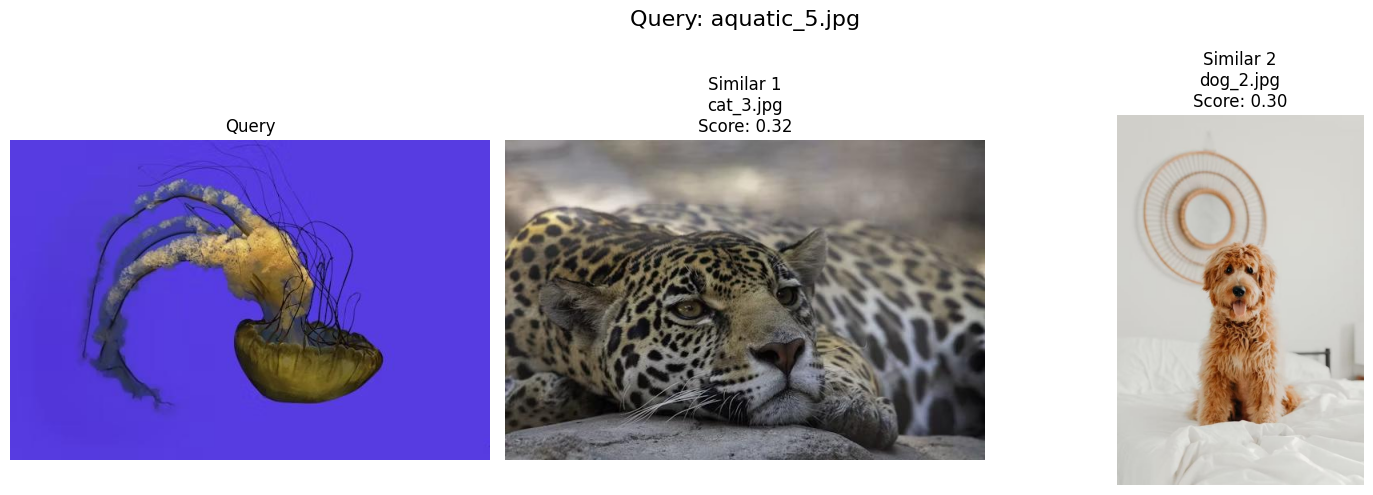

In [ ]:
raw_queries = ["dog", "desserts_3.jpg", "mountain", "aquatic_5.jpg"]
resolved_queries = []

for query in raw_queries:
    if query in image_names:
        resolved_queries.append(query)
    else:
        found = False
        for name, caption in captions.items():
            if query.lower() in caption.lower():
                resolved_queries.append(name)
                found = True
                break
        if not found:
            print(f"Query '{query}' not found in any caption or filename.")

print("\nResolved Queries:")
for q in resolved_queries:
    print(f" → {q}")

# ==== Step 5: Find Top-2 Similar Images ====
def find_top_k_similar_for_queries(query_images, signature_matrix, image_names, k=2):
    results = {}
    for query_image in query_images:
        try:
            query_idx = image_names.index(query_image)
        except ValueError:
            print(f"Image '{query_image}' not found.")
            continue

        query_sig = signature_matrix[:, query_idx]
        similarities = []
        for i, name in enumerate(image_names):
            if i == query_idx:
                continue
            sim = np.mean(query_sig == signature_matrix[:, i])
            similarities.append((name, sim))

        similarities.sort(key=lambda x: x[1], reverse=True)
        results[query_image] = similarities[:k]
    return results

top_k_results = find_top_k_similar_for_queries(resolved_queries, signature_matrix, image_names, k=2)

# ==== Step 6: Visualize Results ====
def show_similar_images(query_results, image_dir="converted_images"):
    for query_img, similar_list in query_results.items():
        fig, axs = plt.subplots(1, 3, figsize=(15, 5))
        fig.suptitle(f"Query: {query_img}", fontsize=16)

        # Query image
        try:
            axs[0].imshow(Image.open(os.path.join(image_dir, query_img)))
            axs[0].set_title("Query")
            axs[0].axis("off")
        except Exception as e:
            axs[0].set_title("Query Not Found")
            axs[0].axis("off")
            print(f"Error loading query image '{query_img}': {e}")

        # Similar images
        for i, (sim_img, score) in enumerate(similar_list):
            try:
                axs[i+1].imshow(Image.open(os.path.join(image_dir, sim_img)))
                axs[i+1].set_title(f"Similar {i+1}\n{sim_img}\nScore: {score:.2f}")
                axs[i+1].axis("off")
            except Exception as e:
                axs[i+1].set_title(f"Error loading {sim_img}")
                axs[i+1].axis("off")
                print(f"Error loading similar image '{sim_img}': {e}")

        plt.tight_layout()
        plt.show()

# ==== Step 7: Run Visualization ====
show_similar_images(top_k_results, image_dir=image_directory)

In [ ]:
!pip install datasketch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.2/89.2 kB 2.2 MB/s eta 0:00:00


In [ ]:
from datasketch import MinHash
import re
import numpy as np
import pandas as pd

def get_minhash(text, num_perm=128):
    tokens = re.findall(r"\w+", text.lower())
    m = MinHash(num_perm=num_perm)
    for token in set(tokens):
        m.update(token.encode('utf8'))
    return m

minhashes = [get_minhash(text) for text in caption_texts]

minhash_sim_matrix = np.zeros((len(minhashes), len(minhashes)))
for i in range(len(minhashes)):
    for j in range(len(minhashes)):
        minhash_sim_matrix[i][j] = minhashes[i].jaccard(minhashes[j])

minhash_df = pd.DataFrame(minhash_sim_matrix, index=image_names, columns=image_names)
minhash_df.to_csv("minhash_similarity_matrix.csv")
print("MinHash similarity matrix saved to minhash_similarity_matrix.csv")


MinHash similarity matrix saved to minhash_similarity_matrix.csv


In [ ]:
import json
import pandas as pd
import numpy as np
import re
from datasketch import MinHash

# Load captions
with open("image_captions.json", "r") as f:
    captions = json.load(f)

image_names = list(captions.keys())
caption_texts = [captions[name] for name in image_names]

# Function to compute MinHash
def get_minhash(text, num_perm=128):
    tokens = re.findall(r"\w+", text.lower())
    m = MinHash(num_perm=num_perm)
    for token in set(tokens):
        m.update(token.encode("utf8"))
    return m

# Generate MinHash signatures for all captions
minhashes = [get_minhash(caption) for caption in caption_texts]

# Build Top-3 MinHash similarity matrix
top_k = 3
N = len(minhashes)
minhash_top3_matrix = np.zeros((N, N))

for i in range(N):
    sims = []
    for j in range(N):
        if i != j:
            sim = minhashes[i].jaccard(minhashes[j])
            sims.append((j, sim))
    # Sort and keep only top 3
    top3 = sorted(sims, key=lambda x: x[1], reverse=True)[:top_k]
    for j_idx, score in top3:
        minhash_top3_matrix[i][j_idx] = score

# Create DataFrame
df_top3 = pd.DataFrame(minhash_top3_matrix, index=image_names, columns=image_names)

# Save matrix
df_top3.to_csv("mminhash_top3_similarity_matrix.csv")
print("Saved top-3 MinHash similarity matrix to minhash_top3_similarity_matrix.csv")


Saved top-3 MinHash similarity matrix to minhash_top3_similarity_matrix.csv
